In [ ]:
import os
import math
import random
import spacy

!python -m spacy download en
!python -m spacy download de
!pip install pytorch-nlp

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# for tokenizing the english sentences
spacy_en = spacy.load('en')
# for tokenizing the german sentences
spacy_de = spacy.load('de')

GOOGLE_COLAB = True
data_dir = ''

if GOOGLE_COLAB:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive') 
    data_dir = '/content/gdrive/My Drive/colab/translation-seq2seq/'
    os.listdir(data_dir)     

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
     |████████████████████████████████| 92kB 3.7MB/s 
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Build dataset

In [ ]:
def tokenize_de(text):
    # tokenizes the german text into a list of strings(tokens) and reverse it
    # we are reversing the input sentences, as it is observed 
    # by reversing the inputs we will get better results
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]     # list[::-1] used to reverse the list


def tokenize_en(text):
    # tokenizes the english text into a list of strings(tokens)
    return [tok.text for tok in spacy_en.tokenizer(text)]
    
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

print('Loading data...')
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))
print('Finished!')

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(f"src: {vars(train_data.examples[0])['src']}")
print(f"trg: {vars(train_data.examples[0])['trg']}")

Loading data...
Finished!
Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000
src: ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei']
trg: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


# Visualize sentence lengths

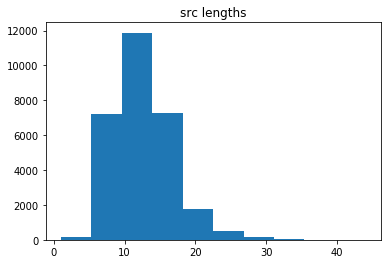

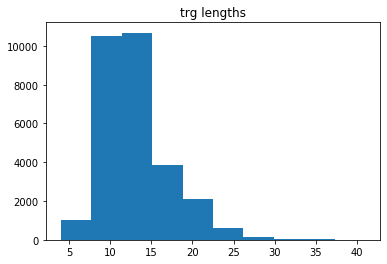

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
src_lens = np.array([len(vars(train_data.examples[i])['src']) for i in range(len(train_data.examples))])
trg_lens = np.array([len(vars(train_data.examples[i])['trg']) for i in range(len(train_data.examples))])

plt.hist(src_lens)
plt.title('src lengths')
plt.show()

plt.hist(trg_lens)
plt.title('trg lengths')
plt.show()

# Build vocab

In [ ]:
# build the vocab
# consider words which are having atleast min_freq.
# words having less than min_freq will be replaced by <unk> token
print('Building vocabulary...')
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)
print('Finished!')

print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Building vocabulary...
Finished!
Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


In [ ]:
def tensor_to_string(lang, tensor, reverse=False):
    tokens = [lang.vocab.itos[x] for x in tensor if x not in [0,1,2,3]]
    tokens = list(reversed(tokens)) if reverse else tokens
    return " ".join(tokens)

def predict_single_sentence(src, tar):
    # Insert into batch where all but the first entry just zeros
    src_batch = torch.zeros((21, BATCH_SIZE)).long().to(device)
    tar_batch = torch.zeros((15, BATCH_SIZE)).long().to(device)
    src_batch[:, 0] = src[:, 0]
    tar_batch[:, 0] = tar[:, 0]
    
    # Perform forward pass
    output = model(src_batch, tar_batch, teacher_forcing_ratio=0) # no teacher forcing
    
    # Extract first predicted sentence
    pred_token_ids = output[:, 0, :].argmax(dim=1)
    
    src_string = tensor_to_string(SRC, src.squeeze())
    tar_string = tensor_to_string(TRG, tar.squeeze())
    pred_string = tensor_to_string(TRG, pred_token_ids)
    
    print("SRC:", src_string)
    print("TAR:", tar_string)
    print("-"*50)
    print("PRED:", pred_string)
    return pred_token_ids

# Batch size and device

In [ ]:
# define batch size
BATCH_SIZE = 256
print('Using batch size:', BATCH_SIZE)

# use gpu if available, else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Loaded device:', device)

# create data iterators for the data
# padding all the sentences to same length, replacing words by its index,
# bucketing (minimizes the amount of padding by grouping similar length sentences)
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=device)

Using batch size: 256
Loaded device: cuda


# Model

In [ ]:
class Encoder(nn.Module):
    ''' Sequence to sequence networks consists of Encoder and Decoder modules.
    This class contains the implementation of Encoder module.
    Args:
        input_dim: A integer indicating the size of input dimension.
        emb_dim: A integer indicating the size of embeddings.
        hidden_dim: A integer indicating the hidden dimension of RNN layers.
        n_layers: A integer indicating the number of layers.
        dropout: A float indicating dropout.
    '''
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)  # default is time major
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src is of shape [sentence_length, batch_size], it is time major

        # embedded is of shape [sentence_length, batch_size, embedding_size]
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)

        # inputs to the rnn is input, (h, c); if hidden, cell states are not passed means default initializes to zero.
        # input is of shape [sequence_length, batch_size, input_size]
        # hidden is of shape [num_layers * num_directions, batch_size, hidden_size]
        # cell is of shape [num_layers * num_directions, batch_size, hidden_size]
        outputs, (hidden, cell) = self.rnn(embedded)

        # outputs are always from the top hidden layer, if bidirectional outputs are concatenated.
        # outputs shape [sequence_length, batch_size, hidden_dim * num_directions]
        return hidden, cell

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    """
        Applies an attention mechanism on the output features from the decoder.
        Args:
            dim(int): The number of expected features in the output
        Inputs: output, context
            - **output** (batch, output_len, dimensions): tensor containing the output features from the decoder.
            - **context** (batch, input_len, dimensions): tensor containing features of the encoded input sequence.
        Outputs: output, attn
            - **output** (batch, output_len, dimensions): tensor containing the attended output features from the decoder.
            - **attn** (batch, output_len, input_len): tensor containing attention weights.
        Attributes:
            linear (torch.nn.Linear): applies a linear transformation to the incoming data: :math:`y = Ax + b`.
        Examples::
            >>> attention = seq2seq.models.Attention(256)
            >>> context = Variable(torch.randn(5, 3, 256))
            >>> output = Variable(torch.randn(5, 5, 256))
            >>> output, attn = attention(output, context)
    """
    def __init__(self, dim):
        super(Attention, self).__init__()
        self.linear = nn.Linear(dim*2, dim)

    def forward(self, output, context):
        batch_size = output.size(0)
        hidden_size = output.size(2)
        input_size = context.size(1)
        
        # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
        attn = torch.bmm(output, context.transpose(1, 2))
        attn = F.softmax(attn.view(-1, input_size), dim=1).view(batch_size, -1, input_size)

        # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        mix = torch.bmm(attn, context)

        # concat -> (batch, out_len, 2*dim)
        combined = torch.cat((mix, output), dim=2)
        
        # output -> (batch, out_len, dim)
        output = torch.tanh(self.linear(combined.view(-1, 2 * hidden_size))).view(batch_size, -1, hidden_size)

        return output, attn

In [ ]:
class AttentionDecoder(nn.Module):
    ''' This class contains the implementation of Decoder Module.
    Args:
        embedding_dim: A integer indicating the embedding size.
        output_dim: A integer indicating the size of output dimension.
        hidden_dim: A integer indicating the hidden size of rnn.
        n_layers: A integer indicating the number of layers in rnn.
        dropout: A float indicating the dropout.
    '''
    def __init__(self, embedding_dim, output_dim, hidden_dim, n_layers, dropout):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.attention = Attention(hidden_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input is of shape [batch_size]
        # hidden is of shape [n_layer * num_directions, batch_size, hidden_size]
        # cell is of shape [n_layer * num_directions, batch_size, hidden_size]

        input = input.unsqueeze(0)
        # input shape is [1, batch_size]. reshape is needed rnn expects a rank 3 tensors as input.
        # so reshaping to [1, batch_size] means a batch of batch_size each containing 1 index.

        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        # embedded is of shape [1, batch_size, embedding_dim]
        
        # Attention layer
        att_output, attn = self.attention(embedded.transpose(0,1), hidden.transpose(0,1))

        output, (hidden, cell) = self.rnn(att_output.transpose(0,1), (hidden, cell))
        # generally output shape is [sequence_len, batch_size, hidden_dim * num_directions]
        # generally hidden shape is [num_layers * num_directions, batch_size, hidden_dim]
        # generally cell shape is [num_layers * num_directions, batch_size, hidden_dim]

        # sequence_len and num_directions will always be 1 in the decoder.
        # output shape is [1, batch_size, hidden_dim]
        # hidden shape is [num_layers, batch_size, hidden_dim]
        # cell shape is [num_layers, batch_size, hidden_dim]

        predicted = self.linear(output.squeeze(0))  # linear expects as rank 2 tensor as input
        # predicted shape is [batch_size, output_dim]

        return predicted, hidden, cell

In [ ]:
class Decoder(nn.Module):
    ''' This class contains the implementation of Decoder Module.
    Args:
        embedding_dim: A integer indicating the embedding size.
        output_dim: A integer indicating the size of output dimension.
        hidden_dim: A integer indicating the hidden size of rnn.
        n_layers: A integer indicating the number of layers in rnn.
        dropout: A float indicating the dropout.
    '''
    def __init__(self, embedding_dim, output_dim, hidden_dim, n_layers, dropout):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input is of shape [batch_size]
        # hidden is of shape [n_layer * num_directions, batch_size, hidden_size]
        # cell is of shape [n_layer * num_directions, batch_size, hidden_size]

        input = input.unsqueeze(0)
        # input shape is [1, batch_size]. reshape is needed rnn expects a rank 3 tensors as input.
        # so reshaping to [1, batch_size] means a batch of batch_size each containing 1 index.

        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        # embedded is of shape [1, batch_size, embedding_dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # generally output shape is [sequence_len, batch_size, hidden_dim * num_directions]
        # generally hidden shape is [num_layers * num_directions, batch_size, hidden_dim]
        # generally cell shape is [num_layers * num_directions, batch_size, hidden_dim]

        # sequence_len and num_directions will always be 1 in the decoder.
        # output shape is [1, batch_size, hidden_dim]
        # hidden shape is [num_layers, batch_size, hidden_dim]
        # cell shape is [num_layers, batch_size, hidden_dim]

        predicted = self.linear(output.squeeze(0))  # linear expects as rank 2 tensor as input
        # predicted shape is [batch_size, output_dim]

        return predicted, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    ''' This class contains the implementation of complete sequence to sequence network.
    It uses to encoder to produce the context vectors.
    It uses the decoder to produce the predicted target sentence.
    Args:
        encoder: A Encoder class instance.
        decoder: A Decoder class instance.
    '''
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src is of shape [sequence_len, batch_size]
        # trg is of shape [sequence_len, batch_size]
        # if teacher_forcing_ratio is 0.5 we use ground-truth inputs 50% of time and 50% time we use decoder outputs.

        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # to store the outputs of the decoder
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size)

        # context vector, last hidden and cell state of encoder to initialize the decoder
        hidden, cell = self.encoder(src)

        # first input to the decoder is the <sos> tokens
        decoder_input = trg[0, :]
        
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[t] = output
            
            # pick next token to feed the decoder
            top1 = output.argmax(dim=1)
            use_teacher_force = random.random() < teacher_forcing_ratio
            decoder_input = (trg[t] if use_teacher_force else top1)

        # outputs is of shape [sequence_len, batch_size, output_dim]
        return outputs

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Example model

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256   # encoder embedding size
DEC_EMB_DIM = 256   # decoder embedding size (can be different from encoder embedding size)
HID_DIM = 256       # hidden dimension (must be same for encoder & decoder)
N_LAYERS = 2        # number of rnn layers (must be same for encoder & decoder)
ENC_DROPOUT = 0.5   # encoder dropout
DEC_DROPOUT = 0.5   # decoder dropout (can be different from encoder droput)

# Set up Model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = AttentionDecoder(DEC_EMB_DIM, OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
model = Seq2Seq(enc, dec).to(device)

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi['<pad>'])

print('Number of params:', count_parameters(model))

Number of params: 7270661


## Set up dummy pair

In [ ]:
src = torch.LongTensor(21, BATCH_SIZE).random_(10).to(device)
tar = torch.LongTensor(15, BATCH_SIZE).random_(10).to(device)

## Run forward pass

In [ ]:
outputs = model.forward(src, tar)
output0 = outputs[:, 0, :]
output0.argmax(dim=1)
tensor_to_string(TRG, output0.argmax(dim=1))

'records ink crew uses uses dusk arrow ceremony office lakeside daytime high book headgear'

In [ ]:
sum(outputs[:, 0, :][4])

tensor(0.4660, grad_fn=<AddBackward0>)

In [ ]:
output0.argmax(dim=1)

tensor([5892, 4374, 4374, 4374,  579,  579,  579, 3589, 4509,  926, 3096, 3589,
         680, 4374, 2425])

# Fine-grained example
## Forward pass through encoder

In [ ]:
hidden, cell = enc(src)
hidden.shape, cell.shape

(torch.Size([2, 256, 256]), torch.Size([2, 256, 256]))

## Set up decoder

In [ ]:
embedding = nn.Embedding(OUTPUT_DIM, DEC_EMB_DIM).to(device)
rnn = nn.LSTM(DEC_EMB_DIM, HID_DIM, N_LAYERS, dropout=DEC_DROPOUT).to(device)
linear = nn.Linear(HID_DIM, OUTPUT_DIM).to(device)
dropout = nn.Dropout(DEC_DROPOUT).to(device)

## Run through embedding layer

In [ ]:
# transform 
decoder_input = tar[0].unsqueeze(0)

# Embed
embedded = embedding(decoder_input)
embedded = dropout(embedded)

print("hidden shape", hidden.shape)
print("cell shape", cell.shape)
print("embedded shape", embedded.shape)

hidden shape torch.Size([2, 256, 256])
cell shape torch.Size([2, 256, 256])
embedded shape torch.Size([1, 256, 256])


## Run through attention layer

In [ ]:
# Attention layer
attention = Attention(HID_DIM).to(device)
output, attn = attention(embedded.transpose(0,1), hidden.transpose(0,1))
print("output shape", output.shape)

output shape torch.Size([256, 1, 256])


## Run through RNN layer

In [ ]:
output, (hidden, cell) = rnn(output.transpose(0,1), (hidden, cell))
output.shape

torch.Size([1, 256, 256])

# Example: Eval single sentence

In [ ]:
# Extract single sentence
src_single = src[:, 0].unsqueeze(1)
tar_single = tar[:, 0].unsqueeze(1)
src_single.shape, tar_single.shape

(torch.Size([21, 1]), torch.Size([15, 1]))

In [ ]:
predicted_ids = predict_single_sentence(src_single, tar_single)

SRC: . , . . einem , , ein einem
TAR: in in a on . the a
--------------------------------------------------
PRED: zune 63 circus uses uses strikes picture picture booth arrow foreign dusk booth arrow arrow


In [ ]:
predicted_ids

tensor([5892, 4564, 2690,  579,  579, 3715,  134,  134,  906, 2425,  990, 1703,
         906, 2425, 2425])

# Train func

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    ''' Training loop for the model to train.
    Args:
        model: A Seq2Seq model instance.
        iterator: A DataIterator to read the data.
        optimizer: Optimizer for the model.
        criterion: loss criterion.
        clip: gradient clip value.
    Returns:
        epoch_loss: Average loss of the epoch.
    '''
    #  some layers have different behavior during train/and evaluation (like BatchNorm, Dropout) so setting it matters.
    model.train()
    # loss
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # trg is of shape [sequence_len, batch_size]
        # output is of shape [sequence_len, batch_size, output_dim]
        output = model(src, trg)
        output = output.to(device)

        # loss function works only 2d logits, 1d targets
        # so flatten the trg, output tensors. Ignore the <sos> token
        # trg shape shape should be [(sequence_len - 1) * batch_size]
        # output shape should be [(sequence_len - 1) * batch_size, output_dim]

        loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))

        # backward pass
        loss.backward()

        # clip the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update the parameters
        optimizer.step()

        epoch_loss += loss.item()
        if i > 0 and i % 10 == 0: print("Train Loss:", loss.item())

    # return the average loss
    return epoch_loss / len(iterator)

# Eval func

In [ ]:
def evaluate(model, iterator, criterion):
    ''' Evaluation loop for the model to evaluate.
    Args:
        model: A Seq2Seq model instance.
        iterator: A DataIterator to read the data.
        criterion: loss criterion.
    Returns:
        epoch_loss: Average loss of the epoch.
    '''
    #  some layers have different behavior during train/and evaluation (like BatchNorm, Dropout) so setting it matters.
    model.eval()
    # loss
    epoch_loss = 0

    # we don't need to update the model parameters. only forward pass.
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0)     # turn off the teacher forcing
            output = output.to(device)

            # loss function works only 2d logits, 1d targets
            # so flatten the trg, output tensors. Ignore the <sos> token
            # trg shape shape should be [(sequence_len - 1) * batch_size]
            # output shape should be [(sequence_len - 1) * batch_size, output_dim]
            loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Train Loop

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256   # encoder embedding size
DEC_EMB_DIM = 256   # decoder embedding size (can be different from encoder embedding size)
HID_DIM = 256       # hidden dimension (must be same for encoder & decoder)
N_LAYERS = 2        # number of rnn layers (must be same for encoder & decoder)
ENC_DROPOUT = 0.5   # encoder dropout
DEC_DROPOUT = 0.5   # decoder dropout (can be different from encoder droput)

# Set up Model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
#dec = AttentionDecoder(DEC_EMB_DIM, OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
dec = Decoder(DEC_EMB_DIM, OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
model = Seq2Seq(enc, dec).to(device)

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi['<pad>'])

import pickle
losses_file = data_dir + 'losses.pickle'

train_losses = []
val_losses = []

N_EPOCHS = 50           # number of epochs
CLIP = 10               # gradient clip value
SAVE_DIR = data_dir     # directory name to save the models.

from datetime import datetime
dateTimeObj = datetime.now()
timestamp = str(dateTimeObj).replace(' ', '_')
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, timestamp + 'seq2seq_model_no_att.pt')

best_validation_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

# TRAIN!

In [ ]:
import time
start = time.time()

for epoch in range(50):
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    val_loss = evaluate(model, valid_iterator, criterion)
    
    # Log the train and val_losses by saving to disk
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    pickle.dump((train_losses, val_losses), open(losses_file, 'wb'))
    
    print('Epoch finished in:', time.time() - start, 'secs')
    start = time.time()

    if val_loss < best_validation_loss:
        best_validation_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Val. Loss: {val_loss:.3f} | Val. PPL: {math.exp(val_loss):7.3f} |')

Train Loss: 6.219449996948242
Train Loss: 5.311295032501221
Train Loss: 5.251638889312744
Train Loss: 5.123062610626221
Train Loss: 5.190574645996094
Train Loss: 5.095025539398193
Train Loss: 5.104218482971191
Train Loss: 5.026403903961182
Train Loss: 5.003878593444824
Train Loss: 4.983217716217041
Train Loss: 5.043433666229248
Epoch finished in: 272.36446619033813 secs
| Epoch: 001 | Train Loss: 5.400 | Train PPL: 221.483 | Val. Loss: 4.862 | Val. PPL: 129.225 |
Train Loss: 4.942638874053955
Train Loss: 4.9368767738342285
Train Loss: 4.805315017700195
Train Loss: 4.982738494873047
Train Loss: 4.826338768005371
Train Loss: 4.897904396057129
Train Loss: 4.924003601074219
Train Loss: 4.842525482177734
Train Loss: 4.711488723754883
Train Loss: 4.8154215812683105
Train Loss: 4.715877056121826
Epoch finished in: 268.028116941452 secs
| Epoch: 002 | Train Loss: 4.874 | Train PPL: 130.904 | Val. Loss: 4.804 | Val. PPL: 122.044 |
Train Loss: 4.760447025299072
Train Loss: 4.7915568351745605
Tra

# Load model

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256   # encoder embedding size
DEC_EMB_DIM = 256   # decoder embedding size (can be different from encoder embedding size)
HID_DIM = 256       # hidden dimension (must be same for encoder & decoder)
N_LAYERS = 2        # number of rnn layers (must be same for encoder & decoder)
ENC_DROPOUT = 0.5   # encoder dropout
DEC_DROPOUT = 0.5   # decoder dropout (can be different from encoder droput)

# Set up Model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = AttentionDecoder(DEC_EMB_DIM, OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
model = Seq2Seq(enc, dec).to(device)

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi['<pad>'])

In [ ]:
model_name = data_dir + 'rnn_att_256.pt'

In [ ]:
# load the parameters(state_dict) that gave the best validation loss and run the model to test.
model.load_state_dict(torch.load(model_name, map_location=device))

In [ ]:
test_loss = evaluate(model, valid_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.487 | Test PPL:  32.692 |


# Plot losses

In [ ]:
import matplotlib.pyplot as plt
import pickle
import matplotlib
font = {'size'   : 22, }
matplotlib.rc('font', **font)

def plot_losses(filepath, title='Training error'):
    modelname = filepath.split('.')[0]
    train_loss, val_loss = pickle.load(open(filepath, 'rb'))
    
    plt.figure(figsize=[20,10])
    plt.xlabel('Epoch')
    plt.ylabel('CE Loss')
    plt.title(title)
    plt.plot(train_loss, linewidth=5)
    plt.plot(val_loss, linewidth=5)
    plt.legend(['train', 'val'])
    plt.savefig(modelname + '.png')
    plt.show()
    
    print('min val loss:', min(val_loss))

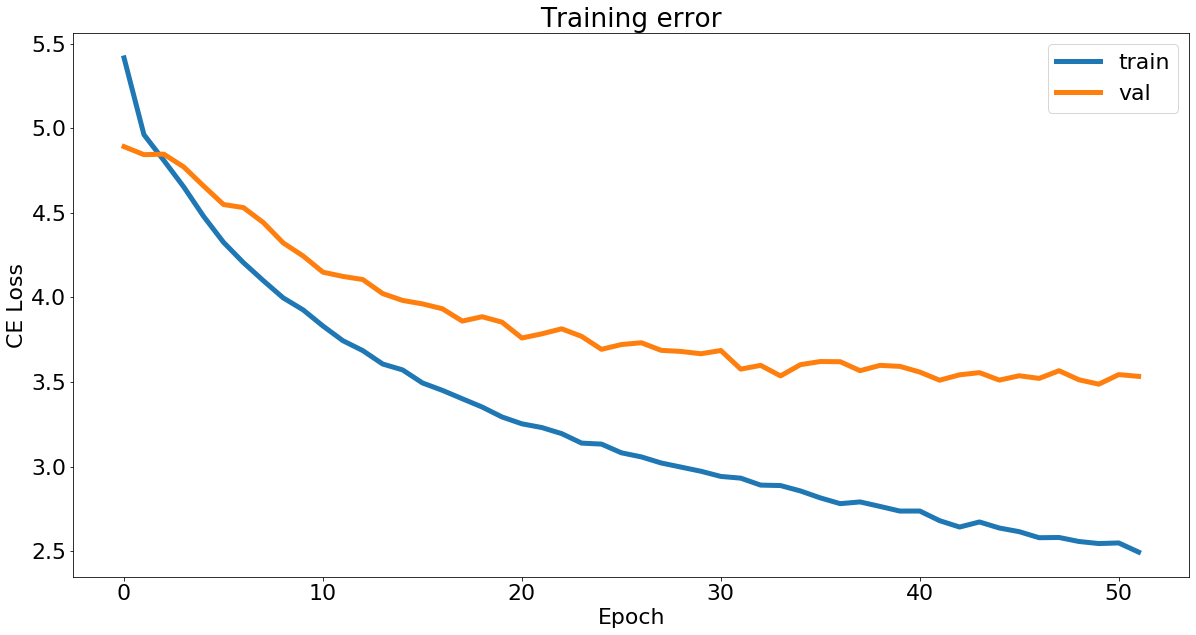

min val loss: 3.4871419072151184


In [ ]:
plot_losses(data_dir + 'rnn-50-losses.pickle')

In [ ]:
def flatten_batch_iterator(iterator):
    'Flattens a batch iterator to a list'
    flat = []
    for batch in iterator:
        flat += [row for row in batch]
    return flat

def find_pair(LANG, id_array, txt, ids):
    x = remove_tags(LANG, id_array)
    i = ids.index(x)
    return txt[i]

def tokens_to_tensor(LANG, tokens, reverse=False):
    idx = [LANG.vocab.stoi[t] for t in tokens]
    if reverse: idx = list(reversed(idx))
    return idx

def remove_tags(LANG, idx):
    ignore = [LANG.vocab.stoi['<pad>'], LANG.vocab.stoi['<sos>'], LANG.vocab.stoi['<eos>'], LANG.vocab.stoi['zune']]
    return [i for i in idx if i not in ignore]

def tensor_to_tokens(LANG, tensor, reverse=False):
    tensor = remove_tags(LANG, tensor)
    tokens = [LANG.vocab.itos[x] for x in tensor]
    tokens = list(reversed(tokens)) if reverse else tokens
    return tokens

def get_pred_tar_pairs(model, batch_iter):
    'predict on batches and finds the untouched txt sentence which matches the target.'
    TARS = []
    PREDS = []
    SRCS = []

    with torch.no_grad():
        for batch in valid_iterator:  
            src = batch.src
            trg = batch.trg

            # Forward pass
            output = model(src, trg)
            
            # Argmax over vocab and get the predicted tokens
            pred = output.argmax(dim=2)
            
            for x in pred.transpose(0,1):
                # Convert predicted token to tensor
                pred_tokens = tensor_to_tokens(TRG, x)
                PREDS.append(pred_tokens)
            
            for x in trg.transpose(0,1):
                # Find the untouched sentence in the validation set
                x = x.tolist()
                tar_tokens = find_pair(TRG, x, valid_trg_txt, valid_trg_idx)
                TARS.append(tar_tokens)
    
    return PREDS, TARS

from torchnlp.metrics import get_moses_multi_bleu
def bleu(tar, pred): 
    'Calculates moses bleu given two arrays of str tokens'
    tar, pred = ' '.join(tar), ' '.join(pred)
    return get_moses_multi_bleu([tar], [pred])

def bleu_scoring(model, valid_iter):
    print('Predicting on batches...')
    preds, tars = get_pred_tar_pairs(model, valid_iter)

    print('Computing bleus')
    bleu_scores = np.array([bleu(tar, pred) for pred, tar in zip(preds, tars)])
    bleu_scores = bleu_scores[bleu_scores != None] # Filter out division by 0 errors

    mean_bleu = bleu_scores.mean()
    print('-'*50)
    print('Mean validation BLEU:', mean_bleu)
    print('-'*50)

    for target, predicted in list(zip(tars, preds))[:10]:
        print('Target (eng):', ' '.join(target))
        print('Predicted (eng):', ' '.join(predicted))
        print(' ')

    return preds, tars, bleu_scores, mean_bleu

In [ ]:
# Count number of sentences in test set
n_test = len(test_data.examples)

# extract the text sentences from the test set
test_src_txt = [test_data.examples[i].src for i in range(n_test)]
test_trg_txt = [test_data.examples[i].trg for i in range(n_test)]

# extract the word-index sentences from the test set
test_src_idx = [tokens_to_tensor(SRC, test_src_txt[i]) for i in range(n_test)]
test_trg_idx = [tokens_to_tensor(TRG, test_trg_txt[i]) for i in range(n_test)]

In [53]:
preds, tars, bleu_scores, mean_bleu = bleu_scoring(model, test_iterator)

Predicting on batches...
Computing bleus
--------------------------------------------------
Mean validation BLEU: 10.569014
--------------------------------------------------
Target (eng): people protesting age discrimination in an organized street rally .
Predicted (eng): people are in a <unk> a <unk> <unk> . .
 
Target (eng): two people are riding their bicycles on a dirt road
Predicted (eng): two people riding riding bikes bikes on a road road .
 
Target (eng): a man dressed in green snowboarding on a bench .
Predicted (eng): a man in black rides rides on a a .
 
Target (eng): one boy hoists another boy up on his back .
Predicted (eng): a boy is another boy boy on his shoulders .
 
Target (eng): a waitress stands behind a counter full of cakes .
Predicted (eng): a <unk> is standing a a with of <unk> . .
 
Target (eng): two boys in a tent smile for the camera .
Predicted (eng): two boys in a smile smile for the camera .
 
Target (eng): one older man interviews another in a racing sui